# Spoon, Fork, and Knife Classification using Transfer Learning on a Self-Made Dataset

#### Team :  Harshwardhan Patil, Avinash Pawar, Aoi Minamoto

#### Dataset URL:
https://drive.google.com/drive/folders/1iPzZ5Vlg7XF5KPrxStY6o09zOIf1g54C?usp=sharing

In [1]:
%%capture

# Before starting of the program below code ensures that you have all the necessary libraries installed 
# if not, it installs them.

!pip install numpy
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install opendatasets
!pip install kaggle
!pip install tensorflow
!pip install pillow

## Question 1:

In [2]:
# importing required libraries
import os
import pathlib
import random
import PIL
import PIL.Image
import numpy as np
import tensorflow as tf

In [3]:
# Declaring image properties
import matplotlib.pyplot as plt

plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
# importing warnings package and filtering the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# setting random seed for entire program
np.random.seed(22)

### Question 1.a: 

In [6]:
train_data_dir = pathlib.Path('Dataset/train')

In [7]:
train_image_count = len(list(train_data_dir.glob('*/*.jpg')))
print(train_image_count)

900


In [8]:
test_data_dir = pathlib.Path('Dataset/test')
test_image_count = len(list(test_data_dir.glob('*/*.jpg')))
print(test_image_count)

300


Out of 100% data, we have kept 75% training data and 25% of the testing data.

### Displaying 5 random images per class

In [9]:
def print_images_per_class(data_dir, class_name):
    data = list(data_dir.glob(class_name+'/*'))
    random_numbers = random.sample(range(1, len(data)), 5)
    
    plt.figure(figsize=(5, 5))
    
    for index_i, number in enumerate(random_numbers):
        ax = plt.subplot(1, 5, index_i+1)
        plt.imshow(PIL.Image.open(str(data[number])))
        plt.title(class_name)
        plt.axis("off")

Images in training dataset


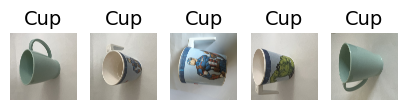

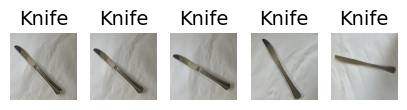

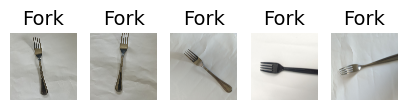

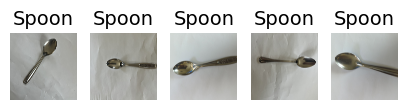

In [10]:
print("Images in training dataset")
print_images_per_class(train_data_dir, 'Cup')
print_images_per_class(train_data_dir, 'Knife')
print_images_per_class(train_data_dir, 'Fork')
print_images_per_class(train_data_dir, 'Spoon')

Images in testing dataset


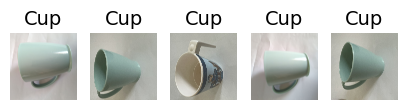

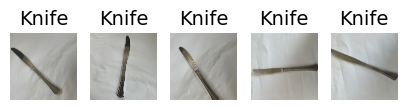

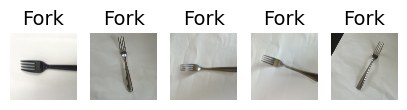

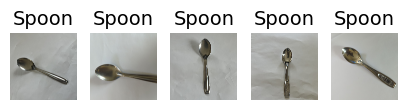

In [11]:
print("Images in testing dataset")
print_images_per_class(test_data_dir, 'Cup')
print_images_per_class(test_data_dir, 'Knife')
print_images_per_class(test_data_dir, 'Fork')
print_images_per_class(test_data_dir, 'Spoon')

### Question 1.b: Splitting the images into training, validation and test dataset

In [12]:
batch_size = 32
img_height = 224
img_width = 224

In [13]:
# Create the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 900 files belonging to 4 classes.
Using 720 files for training.


In [14]:
# Create the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 900 files belonging to 4 classes.
Using 180 files for validation.


In [15]:
# Create the test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    validation_split=None,
    subset=None,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 300 files belonging to 4 classes.


In [16]:
class_names = train_ds.class_names
n_classes = len(class_names)
print(class_names)

['Cup', 'Fork', 'Knife', 'Spoon']


### Question 1.c: doing preprocessing and data augmentation

In [17]:
augmentation_pipeline = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=180, width=180, crop_to_aspect_ratio=True),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),    
])

In [18]:
# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (augmentation_pipeline(x), y))
val_ds = val_ds.map(lambda x, y: (augmentation_pipeline(x), y))
test_ds = test_ds.map(lambda x, y: (augmentation_pipeline(x), y))

# Prefetch the dataset for improved performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

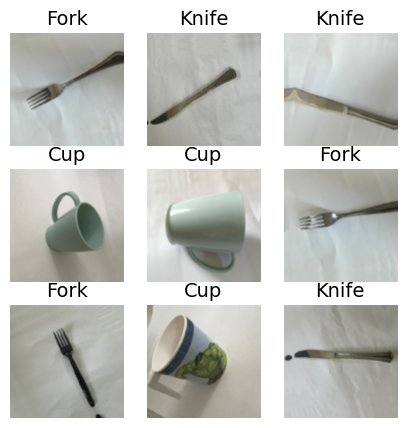

In [19]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

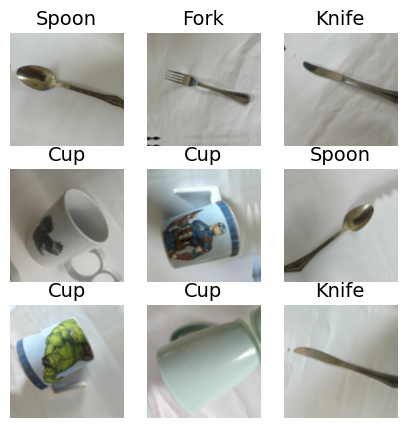

In [20]:
plt.figure(figsize=(5, 5))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

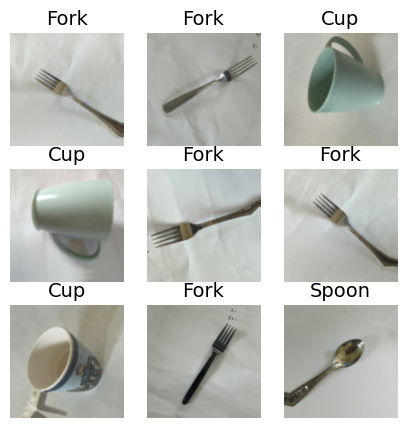

In [21]:
plt.figure(figsize=(5, 5))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Question 1.d: Fine-Tuning pretrained model

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [23]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [24]:
for layer in base_model.layers:
    layer.trainable = False

Here, we are using adam optimizer with learning rate 1e-2.

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
23/23 [==============================] - 27s 1s/step - loss: 89.0001 - accuracy: 0.3583 - val_loss: 20.1531 - val_accuracy: 0.4278
Epoch 2/3
23/23 [==============================] - 27s 1s/step - loss: 19.1552 - accuracy: 0.5083 - val_loss: 28.3133 - val_accuracy: 0.4611
Epoch 3/3
23/23 [==============================] - 27s 1s/step - loss: 13.0486 - accuracy: 0.5931 - val_loss: 9.1614 - val_accuracy: 0.6444


In [26]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
23/23 [==============================] - 58s 2s/step - loss: 1.4936 - accuracy: 0.4403 - val_loss: 165.1978 - val_accuracy: 0.2944
Epoch 2/20
23/23 [==============================] - 52s 2s/step - loss: 0.9660 - accuracy: 0.5611 - val_loss: 946.9922 - val_accuracy: 0.2611
Epoch 3/20
23/23 [==============================] - 52s 2s/step - loss: 0.7518 - accuracy: 0.6958 - val_loss: 114.8772 - val_accuracy: 0.3167
Epoch 4/20
23/23 [==============================] - 52s 2s/step - loss: 0.6370 - accuracy: 0.7083 - val_loss: 29.6834 - val_accuracy: 0.2056
Epoch 5/20
23/23 [==============================] - 52s 2s/step - loss: 0.6070 - accuracy: 0.7514 - val_loss: 8.2851 - val_accuracy: 0.3278
Epoch 6/20
23/23 [==============================] - 52s 2s/step - loss: 0.4763 - accuracy: 0.8028 - val_loss: 2.9939 - val_accuracy: 0.4444
Epoch 7/20
23/23 [==============================] - 52s 2s/step - loss: 0.3870 - accuracy: 0.8500 - val_loss: 2.8672 - val_accuracy: 0.4333
Epoch 8/20
23

In [27]:
model_score = model.evaluate(test_ds)

10/10 [==============================] - 8s 675ms/step - loss: 0.3301 - accuracy: 0.9200


In [28]:
print("For Pretrained Model : ")
print("loss :", model_score[0], "\t Accuracy : ", model_score[1])

For Pretrained Model : 
loss : 0.33012694120407104 	 Accuracy :  0.9200000166893005


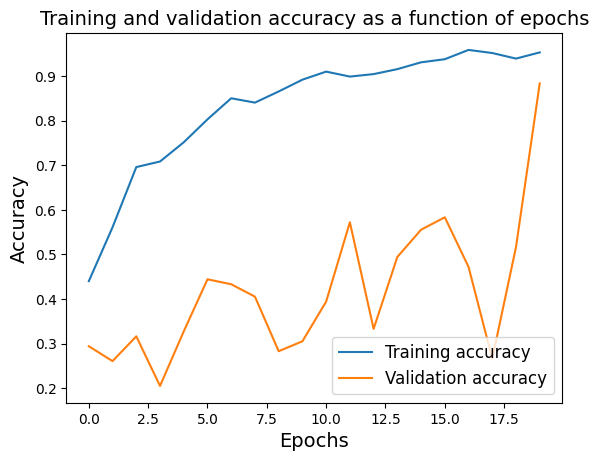

In [29]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy as a function of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

In [30]:
X_test, y_test = next(iter(test_ds))

In [31]:
y_pred = tf.convert_to_tensor(np.argmax(model.predict(X_test), axis=1))

1/1 [==============================] - 1s 1s/step


### Plotting examples of correct/incorrect classifications

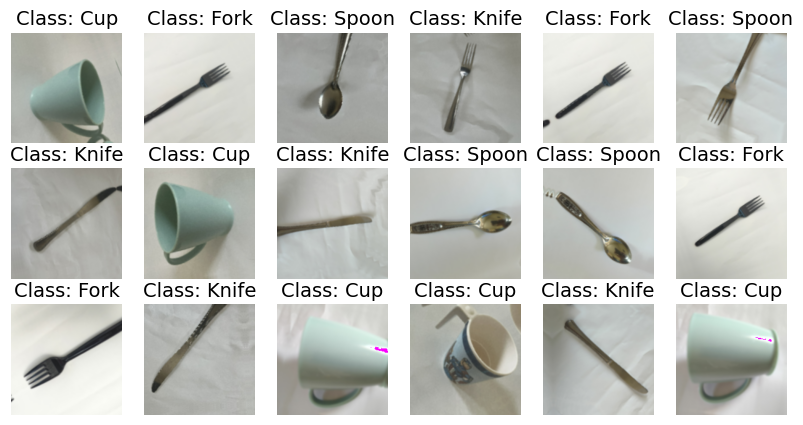

In [32]:
plt.figure(figsize=(10, 5))
for index in range(18):
    plt.subplot(3, 6, index + 1)
    plt.imshow((X_test[index] + 1).numpy().astype("uint8"))  # rescale to 0–1 for imshow()
    plt.title(f"Class: {class_names[y_pred[index]]}")
    plt.axis("off")

plt.show()

### Question 1.e: Training model from scratch

In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

scratch_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])
scratch_model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

In [34]:
scratch_model_history = scratch_model.fit(train_ds, validation_data=val_ds, epochs=25)

Epoch 1/25
23/23 [==============================] - 51s 2s/step - loss: 5336.1646 - accuracy: 0.1889 - val_loss: 2.2920 - val_accuracy: 0.2667
Epoch 2/25
23/23 [==============================] - 49s 2s/step - loss: 59.4611 - accuracy: 0.2361 - val_loss: 2.2689 - val_accuracy: 0.2667
Epoch 3/25
23/23 [==============================] - 48s 2s/step - loss: 2.2575 - accuracy: 0.2458 - val_loss: 2.2451 - val_accuracy: 0.2667
Epoch 4/25
23/23 [==============================] - 48s 2s/step - loss: 2.2337 - accuracy: 0.2458 - val_loss: 2.2216 - val_accuracy: 0.2667
Epoch 5/25
23/23 [==============================] - 48s 2s/step - loss: 2.2107 - accuracy: 0.2306 - val_loss: 2.1986 - val_accuracy: 0.2056
Epoch 6/25
23/23 [==============================] - 48s 2s/step - loss: 2.1876 - accuracy: 0.2250 - val_loss: 2.1761 - val_accuracy: 0.2667
Epoch 7/25
23/23 [==============================] - 48s 2s/step - loss: 2.1667 - accuracy: 0.2417 - val_loss: 2.1543 - val_accuracy: 0.2667
Epoch 8/25
23/23

In [35]:
scratch_model_score = scratch_model.evaluate(test_ds)

10/10 [==============================] - 4s 323ms/step - loss: 1.8536 - accuracy: 0.2500


In [36]:
print("For Pretrained Model : ")
print("loss :", scratch_model_score[0], "\t Accuracy : ", scratch_model_score[1])

For Pretrained Model : 
loss : 1.8536077737808228 	 Accuracy :  0.25


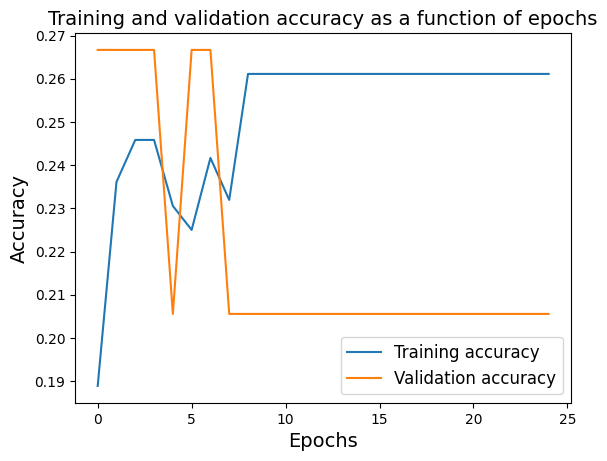

In [37]:
# Plot the training and validation accuracy
plt.plot(scratch_model_history.history['accuracy'], label='Training accuracy')
plt.plot(scratch_model_history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy as a function of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

In [38]:
X_test, y_test = next(iter(test_ds))

In [39]:
y_pred = tf.convert_to_tensor(np.argmax(model.predict(X_test), axis=1))

1/1 [==============================] - 1s 861ms/step


### Plotting examples of correct/incorrect classifications

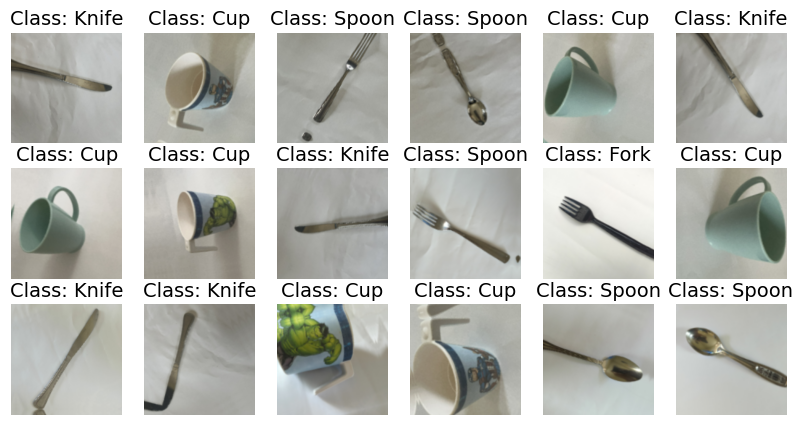

In [40]:
plt.figure(figsize=(10, 5))
for index in range(18):
    plt.subplot(3, 6, index + 1)
    plt.imshow((X_test[index] + 1).numpy().astype("uint8"))  # rescale to 0–1 for imshow()
    plt.title(f"Class: {class_names[y_pred[index]]}")
    plt.axis("off")

plt.show()

## Observations : 

1. The main difference observed when we compated the evaluation criteria between the fine-tuned pretrained model and the model developed from scratch is that the fine-tuned model gave higher accuracy for similar epochs. 
2. After 9 epochs, there is no change in the accuracy for the model developed in scratch, thus either parameter finetuning required or some change in the architecture is required. 

# Acknowledgments: 

We would like to thank Prof. Zoran Tiganj for his guidance on the assignment implementation walkthrough. Also, we have worked according to his suggestion about following code on the github repository of Machine Learning Notebooks by A. Geron.

# References:

[1] Geron, A. (2019). Hands-on machine learning with scikit-learn, keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems (2nd ed.). O’Reilly Media.

[2] Machine Learning Notebooks(8,9,10) on GitHub by A. Geron. https://github.com/ageron/handson-ml2 , https://github.com/ageron/handson-ml3 notebooks for chapter 13 and 14.

[2] API Reference. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/classes.html

[3] API Reference. (n.d.). Pandas. https://pandas.pydata.org/docs/user_guide/index.html

[4] API Reference. (n.d.). NumPy. https://numpy.org/doc/stable/user/index.html#user

[5] Tutorials for Data Augmentation in Tensorflow. https://www.tensorflow.org/tutorials/images/data_augmentation